In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


ModuleNotFoundError: No module named 'librosa'

In [8]:
# Define the directory for the CREMA-D dataset
Crema = "C:\\Users\\dell\\Desktop\\graduation project\\AI04-Grad\\datasets\\CREMA-D\\AudioWAV"
crema_directory_list = os.listdir(Crema)


In [9]:
file_emotion = []
file_path = []

for file in crema_directory_list:
    # Correctly adding the separator
    file_path.append(os.path.join(Crema, file))
    # Storing file emotions based on naming convention
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')



In [10]:
# DataFrame for emotions of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# DataFrame for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)



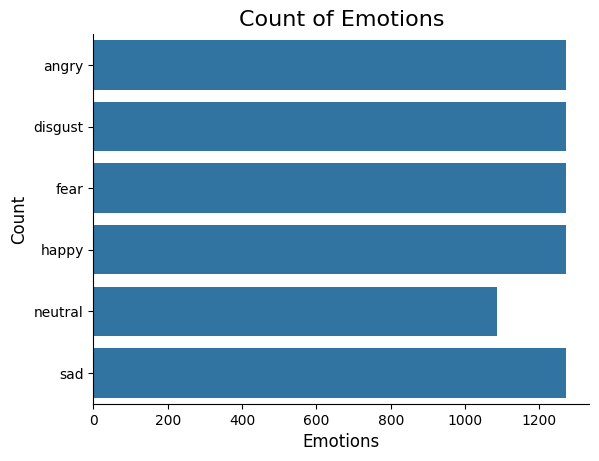

In [11]:
# Visualize the count of emotions
plt.title('Count of Emotions', size=16)
sns.countplot(Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)  # Use waveshow instead of waveplot
    plt.show()


In [13]:
def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()


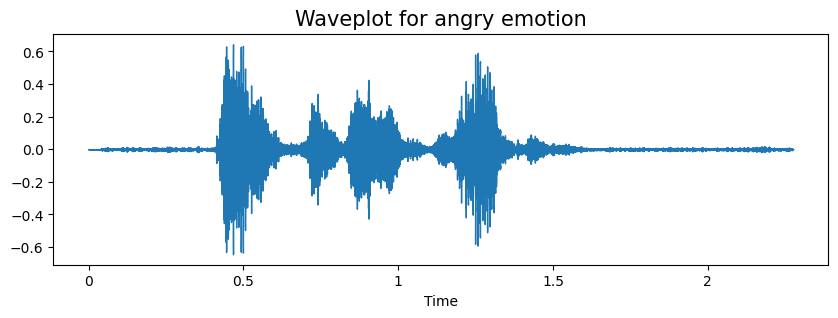

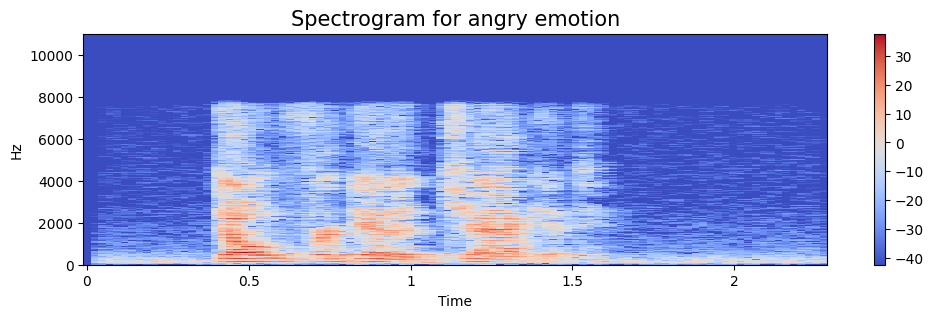

In [14]:
# Define the emotion you're interested in
emotion = 'angry'
# Get the path of the first audio file for the specified emotion
path = np.array(Crema_df.Path[Crema_df.Emotions == emotion])[0]

# Check if the file exists before trying to load it
if os.path.isfile(path):
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(path))
else:
    print(f"File not found: {path}")


In [15]:
#MFCC Extraction:


In [16]:
labels = {'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}
Crema_df.replace({'Emotions':labels},inplace=True)


In [17]:
# Set parameters for MFCC extraction
num_mfcc = 13
n_fft = 2048
hop_length = 512
SAMPLE_RATE = 22050

data = {
    "labels": [],
    "mfcc": []
}


In [18]:
# MFCC Extraction
labels = {'disgust': 0, 'happy': 1, 'sad': 2, 'neutral': 3, 'fear': 4, 'angry': 5}
Crema_df.replace({'Emotions': labels}, inplace=True)

# Set parameters for MFCC extraction
num_mfcc = 13
n_fft = 2048
hop_length = 512
SAMPLE_RATE = 22050

data = {
    "labels": [],
    "mfcc": []
}

# Extract MFCC for each audio file
for i in range(len(Crema_df)):
    data['labels'].append(Crema_df.iloc[i, 0])
    
    # Load the audio file
    signal, sample_rate = librosa.load(Crema_df.iloc[i, 1], sr=SAMPLE_RATE)
    
    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T  # Transpose to match shape
    
    # Store MFCCs
    data["mfcc"].append(np.asarray(mfcc))
    
    # Print progress
    if i % 500 == 0:
        print(f"Processed {i} files")

# Convert to DataFrame for further processing if needed
mfcc_df = pd.DataFrame(data)

# Display the first few rows of the MFCC DataFrame
print(mfcc_df.head())


Processed 0 files
Processed 500 files
Processed 1000 files
Processed 1500 files
Processed 2000 files
Processed 2500 files
Processed 3000 files
Processed 3500 files
Processed 4000 files
Processed 4500 files
Processed 5000 files
Processed 5500 files
Processed 6000 files
Processed 6500 files
Processed 7000 files
   labels                                               mfcc
0       5  [[-620.80884, 0.22685766, 0.22398715, 0.219232...
1       0  [[-518.20026, 121.81351, 19.000422, 43.559875,...
2       4  [[-471.38235, 105.91329, 35.017483, 22.620476,...
3       1  [[-477.59158, 89.06055, 39.2924, 40.103455, 27...
4       3  [[-497.292, 112.72084, 41.057255, 25.869959, 2...


In [19]:
#Padding MFCC to make them of equal length

In [20]:
from keras.preprocessing.sequence import pad_sequences

# Determine the maximum length of MFCC arrays
max_length = max([len(mfcc) for mfcc in data['mfcc']])

# Pad the MFCC arrays
X = pad_sequences(data['mfcc'], maxlen=max_length, padding='post', dtype='float32')

# Convert labels to a NumPy array
y = np.asarray(data["labels"])

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (7442, 216, 13)
Shape of y: (7442,)


In [21]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape


(7442, 216, 13)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)


In [23]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)


(5357, 216, 13) (5357,) (1340, 216, 13) (1340,) (745, 216, 13) (745,)


In [24]:
#Model

In [25]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(6, activation='softmax'))

    return model


In [26]:
# create network
input_shape = (None,13)
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 128)      │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,662 (494.77 KB)

 Trainable params: 126,662 (494.77 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
#Training

In [28]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)


Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 55s 290ms/step - accuracy: 0.1799 - loss: 1.7880 - val_accuracy: 0.2075 - val_loss: 1.7750
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 50s 295ms/step - accuracy: 0.2261 - loss: 1.7665 - val_accuracy: 0.2194 - val_loss: 1.7596
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 50s 295ms/step - accuracy: 0.2955 - loss: 1.6437 - val_accuracy: 0.3604 - val_loss: 1.5407
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 51s 305ms/step - accuracy: 0.3508 - loss: 1.5524 - val_accuracy: 0.3873 - val_loss: 1.5271
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - accuracy: 0.3747 - loss: 1.5311 - val_accuracy: 0.3403 - val_loss: 1.5979
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - accuracy: 0.3600 - loss: 1.5335 - val_accuracy: 0.3612 - val_loss: 1.5319
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 51s 301ms/step - accuracy: 0.3881 - loss: 1.5138 - val_accuracy: 0.3485 - val_loss: 1.5509
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 49s 291ms/step - accuracy: 0.3706 - loss: 1

In [29]:
#Evaluation

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.4510067105293274


In [31]:
model.save('Speech-Emotion-Recognition-Model.h5')


In [32]:
def preprocess_audio(file_path, num_mfcc=13, n_fft=2048, hop_length=512, sample_rate=22050):
    # Load the audio file
    signal, sample_rate = librosa.load(file_path, sr=sample_rate)
    
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    
    # Transpose the MFCC to match the input shape (time steps, MFCC coefficients)
    mfcc = mfcc.T
    
    # Pad the MFCC features to match the input shape of the model
    mfcc = tf.keras.preprocessing.sequence.pad_sequences([mfcc], maxlen=X.shape[1], padding='post')
    
    return np.array(mfcc)


In [33]:
def predict_emotion(model, file_path):
    # Preprocess the audio file
    mfcc = preprocess_audio(file_path)
    
    # Make a prediction
    prediction = model.predict(mfcc)
    
    # Get the index with the highest probability
    predicted_index = np.argmax(prediction, axis=1)
    
    return predicted_index[0]


In [38]:
# Define the mapping from label to emotion
labels_to_emotions = {0: 'disgust', 1: 'happy', 2: 'sad', 3: 'neutral', 4: 'fear', 5: 'angry'}

# Example: Path to your pre-recorded audio file
file_path = "C:\\Users\\dell\\Desktop\\graduation project\\AI04-Grad\\datasets\\CREMA-D\\AudioWAV\\1001_ITH_FEA_XX.wav"
# Predict the emotion
predicted_label = predict_emotion(model, file_path)
predicted_emotion = labels_to_emotions[predicted_label]

print("Predicted Emotion: ", predicted_emotion)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted Emotion:  angry
